In [1]:
import numpy
import pandas
import seaborn
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec


In [2]:
beam_path = "/Users/ronniyjoseph/Sync/MSI_Fellowship/CHORD/Beam_Models/"
array_path = "/Users/ronniyjoseph/Sync/MSI_Fellowship/CHORD/Array_layout/"

## Array Lay-Out

In [3]:
locs = pandas.read_csv(array_path + "chord_dish_coords_fences_wgap_clean.txt" , header=None, names=["x", "y"], sep=" ")

In [4]:
locs.head()

,x,y
0,309411.720178,5.466340e+06
1,309411.987170,5.466348e+06
2,309412.254161,5.466357e+06
3,309412.521153,5.466365e+06
4,309412.788144,5.466374e+06


/Users/ronniyjoseph/.pyenv/versions/3.7.9/envs/niagara_arpeggio/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


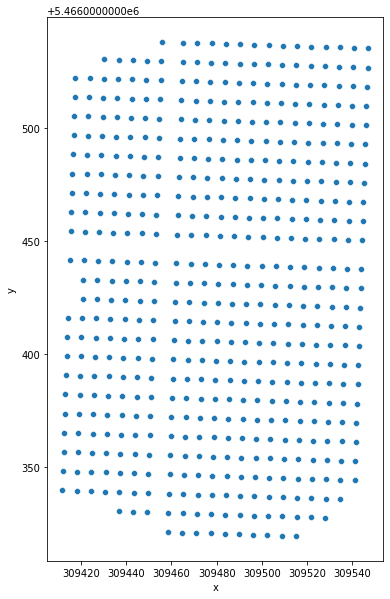

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
ax = seaborn.scatterplot(locs.x, locs.y)
ax.set_aspect('equal')

In [6]:
#shift all coordinate to not be absurdly large
locs = locs - locs.median()
quads1 = locs.loc[(locs['x']<-25) & (locs['y']>20) ]
quads2 = locs.loc[(locs['x']>-25) & (locs['y']>20) ]
quads3 = locs.loc[(locs['x']<-25) & (locs['y']<20) ]
quads4 = locs.loc[(locs['x']>-25) & (locs['y']<20) ]

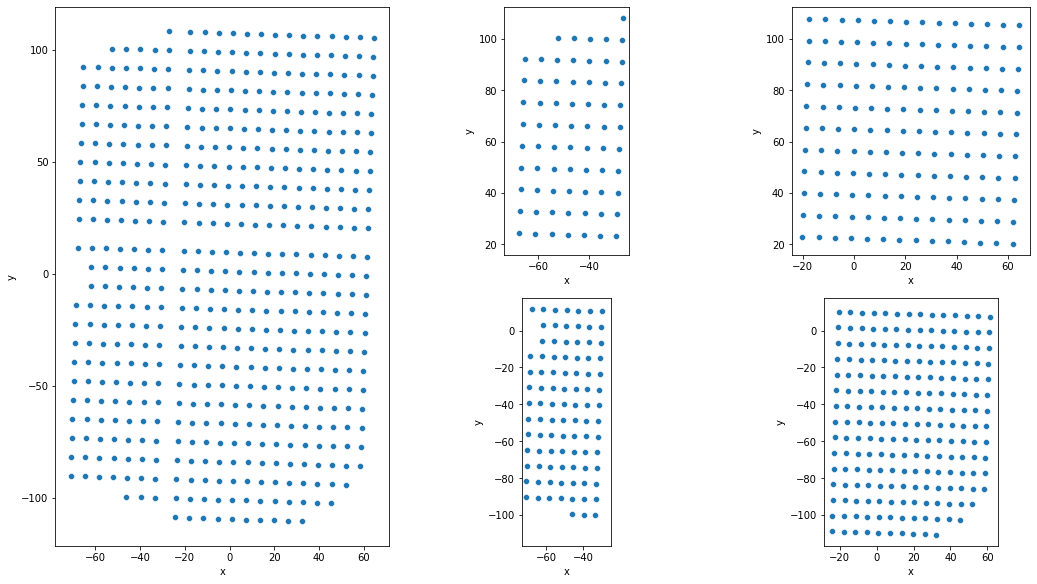

In [7]:
fig = plt.figure(constrained_layout=True, figsize=(15, 8))
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

ax1 = fig.add_subplot(spec[:, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[0, 2], sharey = ax2)
ax4 = fig.add_subplot(spec[1, 1], sharex = ax2)
ax5 = fig.add_subplot(spec[1, 2], sharey = ax4)

seaborn.scatterplot(x=locs.x, y=locs.y, ax=ax1)
seaborn.scatterplot(x=quads1.x, y=quads1.y, ax=ax2)
seaborn.scatterplot(x=quads2.x, y=quads2.y, ax=ax3)
seaborn.scatterplot(x=quads3.x, y=quads3.y, ax=ax4)
seaborn.scatterplot(x=quads4.x, y=quads4.y, ax=ax5)
#ax = seaborn.scatterplot(quads2.x, quads2.y)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')
ax5.set_aspect('equal')


In [10]:
#Rename and reshape to match pyuvsim input: Name Number   BeamID   E          N          U
def reformat(locations):
    new_df = locations.copy()
    new_df["Number"] = numpy.arange(0,new_df.shape[0],1)
    new_df['Name'] = new_df["Number"].astype(str)
    new_df['BeamID'] = 0
    new_df['U'] = 0
    new_df.rename(columns = {'x':'E', 'y':'N'}, inplace = True)
    new_df = new_df[["Name", "Number", "BeamID", "E", "N", "U"]]
    return new_df

full_chord = reformat(locs)
q1_chord = reformat(quads1)
q2_chord = reformat(quads2)
q3_chord = reformat(quads3)
q4_chord = reformat(quads4)


path = "/Users/ronniyjoseph/Sync/MSI_Fellowship/CHORD/Array_Layout/"
full_chord.to_csv(path+ "chord_wgap_full_2020_10.txt", sep='\t', index=False)
q1_chord.to_csv(path+ "chord_wgap_q1_2020_10.txt", sep='\t', index=False)
q2_chord.to_csv(path+ "chord_wgap_q2_2020_10.txt", sep='\t', index=False)
q3_chord.to_csv(path+ "chord_wgap_q3_2020_10.txt", sep='\t', index=False)
q4_chord.to_csv(path+ "chord_wgap_q4_2020_10.txt", sep='\t', index=False)

## Beam Map

In [109]:
phi = numpy.load(beam_path + "/45deg_20m_cable/all_phi.npy")/180*numpy.pi
theta = numpy.load(beam_path + "/45deg_20m_cable/all_theta.npy")/180*numpy.pi
freqs = numpy.load(beam_path + "/45deg_20m_cable/all_freqs.npy")
cst_beams = numpy.load(beam_path +"/45deg_20m_cable/all_beams.npy")

In [110]:
print(phi.shape ,theta.shape ,freqs.shape ,beams.shape)
print(len(numpy.unique(phi)),len(numpy.unique(theta))) 


(720, 361) (720, 361) (13,) (13, 720, 361)
720 361


In [111]:
import healpy 
import pyuvsim

def healpy_plotting(tt, pp, tile_response):
    nside =32
    n_pixels = healpy.nside2npix(nside)
    
    indices = healpy.ang2pix(nside, tt.flatten(), pp.flatten())
    healpixmap = numpy.zeros((n_pixels), dtype=complex)

    healpixmap[indices] += tile_response.flatten()

    healpy.orthview(20*numpy.log10(numpy.abs(healpixmap)), rot =[0,90,180], half_sky=True, norm='none')
    healpy.graticule()

0.0 180.0 -180.0 180.0


0.0 3.141592653589793
0.0 6.274458660919614


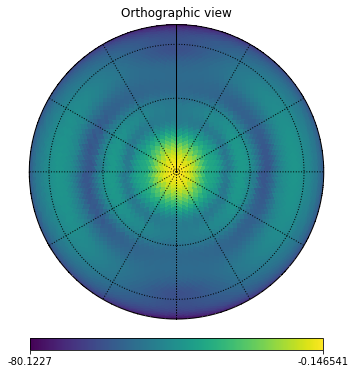

In [112]:
healpy_plotting(theta, phi, cst_beams[0,:]/cst_beams[0,:].max())
print(theta.min(),theta.max())
print(phi.min(), phi.max())

In [126]:
airy_disk = pyuvsim.AnalyticBeam(type='airy', diameter=4.5)
airy_disk.efield_to_power()
airy_beam = airy_disk.interp(phi[0,:181],theta[0,:181],freqs*1e9)[0][0,0,0,0,:]


In [127]:
gaussian = pyuvsim.AnalyticBeam(type='gaussian', diameter=4.5)
gaussian.efield_to_power()
gauss_beam = gaussian.interp(phi[0,:181],theta[0,:181],freqs*1e9)[0][0,0,0,0,:]


(-80.0, 0.0)

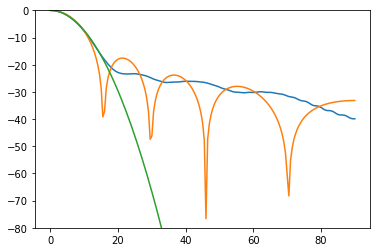

In [129]:
plt.plot(numpy.degrees(theta[0,:181]),10*numpy.log10(abs(cst_beams[0,0,:181])/abs(cst_beams[0,0,:181]).max()))
plt.plot(numpy.degrees(theta[0,:181]),10*numpy.log10(abs(airy_beam)))
plt.plot(numpy.degrees(theta[0,:181]),10*numpy.log10(abs(gauss_beam)))
plt.ylim(-80,0)

## Bug Report

In [36]:
import pyuvsim
import numpy as np

phi = np.linspace(0,np.pi,5)
theta = np.linspace(0,np.pi/2,6)
freqs = np.linspace(135,165,7)*1e6

pp,tt = np.meshgrid(phi,theta)

In [29]:
uniform = pyuvsim.AnalyticBeam(type='uniform')
uniform.efield_to_power()
uniform_beam = airy_disk.interp(pp, tt, freqs)

In [30]:
airy_disk = pyuvsim.AnalyticBeam(type='airy', diameter=4.5)
airy_disk.efield_to_power()
airy_beam = airy_disk.interp(pp, tt, freqs)

In [34]:
gaussian = pyuvsim.AnalyticBeam(type='gaussian', diameter=6)
gaussian.efield_to_power()
gauss_beam = gaussian.interp(pp,tt,freqs)


ValueError: operands could not be broadcast together with shapes (1,6,5) (7,1) 

In [37]:
ppf,ff = np.meshgrid(pp,freqs)

In [40]:
pp.shape

(6, 5)